In [1]:
# preparing notebook for visualization purposes
# (only show outputs between t=0s and t=30s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)

# Applying a pretrained model

In this tutorial, you will learn how to apply `pyannote.audio` models on an audio file, whose manual annotation is depicted below

In [2]:
# clone pyannote-audio Github repository and update ROOT_DIR accordingly
ROOT_DIR = "/Users/bredin/Development/pyannote/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"

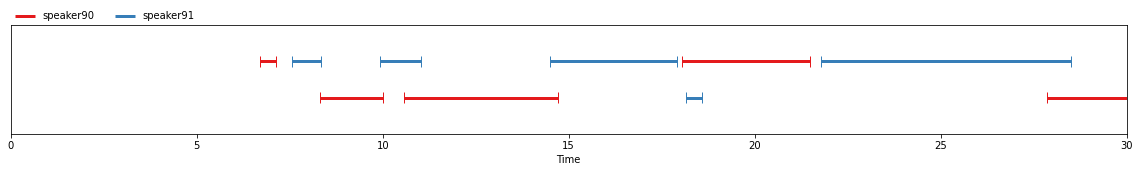

In [3]:
from pyannote.database.util import load_rttm
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"
reference = load_rttm(REFERENCE)["sample"]
reference

## Loading models from 🤗 hub

Pretrained models are available on [🤗 Huggingface model hub](https://hf.co/models?other=pyannote-audio-model) and can be listed by looking for the [`pyannote-audio-model`](https://hf.co/models?other=pyannote-audio-model) tag.

In [4]:
from huggingface_hub import HfApi
available_models = [m.modelId for m in HfApi().list_models(filter="pyannote-audio-model")]
available_models

['pyannote/TestModelForContinuousIntegration',
 'pyannote/embedding',
 'pyannote/segmentation']

Let's load the speaker segmentation model...

In [5]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation")

/Users/bredin/miniconda3/envs/pyannote/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:16: LightningDeprecationWarning: `pytorch_lightning.core.memory.get_memory_profile` and `pytorch_lightning.core.memory.get_gpu_memory_map` have been moved to `pytorch_lightning.utilities.memory` since v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/Users/bredin/miniconda3/envs/pyannote/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:25: LightningDeprecationWarning: `pytorch_lightning.core.memory.LayerSummary` and `pytorch_lightning.core.memory.ModelSummary` have been moved to `pytorch_lightning.utilities.model_summary` since v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


... which consists in SincNet feature extraction (`sincnet`) , LSTM sequence modeling (`lstm`), a few feed-forward layers (`linear`), and a final multi-label `classifier`: 

In [6]:
model.summarize()

  | Name       | Type       | Params | In sizes      | Out sizes                                  
--------------------------------------------------------------------------------------------------------
0 | sincnet    | SincNet    | 42.6 K | [3, 1, 32000] | [3, 60, 115]                               
1 | lstm       | LSTM       | 1.4 M  | [3, 115, 60]  | [[3, 115, 256], [[8, 3, 128], [8, 3, 128]]]
2 | linear     | ModuleList | 49.4 K | ?             | ?                                          
3 | classifier | Linear     | 516    | [3, 115, 128] | [3, 115, 4]                                
4 | activation | Sigmoid    | 0      | [3, 115, 4]   | [3, 115, 4]                                
--------------------------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.892     Total estimated model params size (MB)

More details about the model are provided by its specifications... 

In [7]:
specs = model.specifications
specs

Specifications(problem=<Problem.MULTI_LABEL_CLASSIFICATION: 2>, resolution=<Resolution.FRAME: 1>, duration=5.0, warm_up=(0.0, 0.0), classes=['speaker#1', 'speaker#2', 'speaker#3', 'speaker#4'], permutation_invariant=True)

... which can be understood like that:

* `duration = 5.0`: the model ingests 5s-long audio chunks
* `Resolution.FRAME` and `len(classes) == 4`:  the model output a sequence of frame-wise 4-dimensoinal scores
* `Problem.MULTI_LABEL_CLASSIFICATION` for each frame, more than one speaker can be active at once

To apply the model on the audio file, we wrap it into an `Inference` instance:

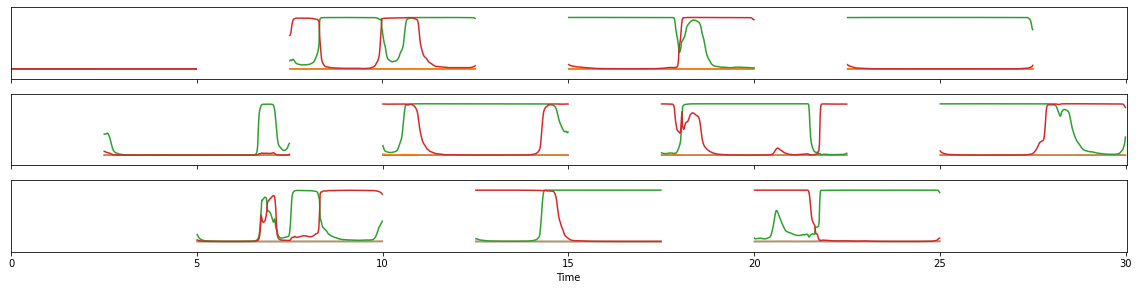

In [8]:
from pyannote.audio import Inference
inference = Inference(model, step=2.5)
output = inference(AUDIO_FILE)
output

For each of the 11 positions of the 5s window, the model outputs a 4-dimensional vector every 16ms (293 frames for 5 seconds), corresponding to the probabilities that each of (up to) 4 speakers is active.   

In [9]:
output.data.shape

(11, 293, 4)

## Processing a file from memory

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary. 

In [10]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


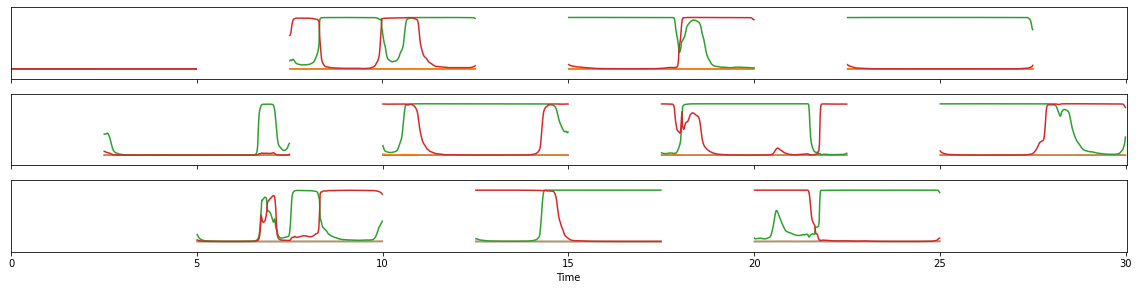

In [11]:
output = inference(audio_in_memory)
output

## Processing part of a file

If needed, `Inference` can be used to process only part of a file:

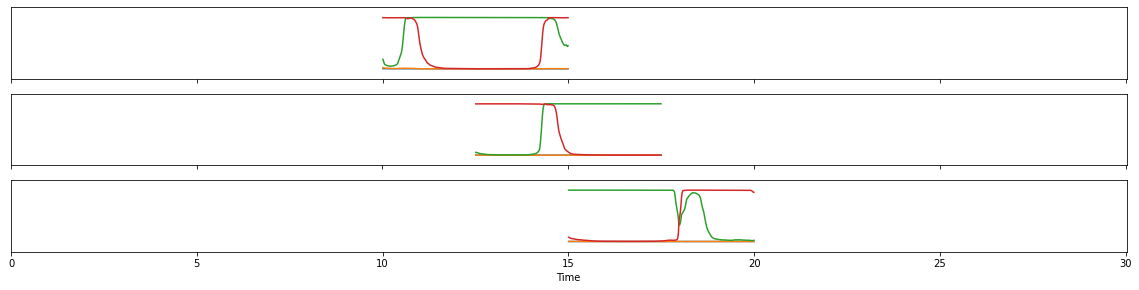

In [12]:
from pyannote.core import Segment
output = inference.crop(AUDIO_FILE, Segment(10, 20))
output